# Introduction
This notebook tries to get the gold medal for the assignment 1 of the Udemy course [Deep Learning A-Z™: Hands-On Artificial Neural Networks](https://www.udemy.com/deeplearning/learn/v4/overview). The goal is to predict a hypothetical bank's customer churn using deep neural networks. The metric is accuracy and the goal medal is considered as the accuracy of %86.

I get the gold medal by using Bayesian optimization for hyper-parameter tuning! I use [Bayesian Optimization Package(https://github.com/fmfn/BayesianOptimization) developed by Fernando Nogueira. This is a simple and easy to use library. It does not have extensive functionality but gets the job done.

# Preprocessing

In [ ]:
from bayes_opt import BayesianOptimization

import numpy as np
import pandas as pd

from tensorflow.contrib.keras.api.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.contrib.keras.api.keras.models import Sequential
from tensorflow.contrib.keras.api.keras.layers import Dense, Dropout

from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import roc_auc_score 
from keras import optimizers

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
# Importing the dataset
dataset = pd.read_csv('Churn_Modelling.csv')
X = dataset.iloc[:, 3:13].values
y = dataset.iloc[:, 13].values
    
# Encoding categorical data
labelencoder_X_1 = LabelEncoder()
X[:, 1] = labelencoder_X_1.fit_transform(X[:, 1])
labelencoder_X_2 = LabelEncoder()
X[:, 2] = labelencoder_X_2.fit_transform(X[:, 2])
onehotencoder = OneHotEncoder(categorical_features = [1])
X = onehotencoder.fit_transform(X).toarray()
X = X[:, 1:]

# Tuning the neural net

Below, I first build a three layer neural network with dropout. Then, I apply ten-fold cross validation and consider the mean accuracy as the performance of the neural net (as suggested by the course). Then, I write a wrapper function around it which iterates over the dropout rate, number of nodes in the hidden layer of the neural net and the number of training epochs.

At the end, I call the Bayesian Optimization to find the optimal combination of these three parameters. With 35 iterations, I achieve a higher accuracy than the grid search used in the course. I also record some statistics for further analysis.

Note that, I do not leave holdout data outside of the validation set to test for overfitting after the hyper-parameters are optimized. In a real scenario one should do that. Here, I wanted to be consistent with the course assignment and make the comparisons fair.

In [5]:
# Info to be saved from the experiment
info = ['roc_mean', 'roc_std', 'acc_mean', 'acc_std', 'tp_mean', 'tp_std', 'tn_mean', 'tn_std', 
        'fp_mean', 'fp_std', 'fn_mean', 'fn_std', 'business_objective_mean', 'business_objective_std']
df = pd.DataFrame(columns=info)

def nncv(rate, num_node, epochs):
            
    def build_classifier():
        classifier = Sequential()
        classifier.add(Dense(units=num_node, kernel_initializer='uniform', activation='relu', input_dim=11))
        classifier.add(Dropout(rate))
        classifier.add(Dense(units=num_node, kernel_initializer='uniform', activation='relu'))
        classifier.add(Dropout(rate))
        classifier.add(Dense(units=1, kernel_initializer='uniform', activation='sigmoid'))
        classifier.compile(optimizer='adam', loss= 'binary_crossentropy', metrics=['accuracy'])
        return classifier
            
    kf = KFold(n_splits=10)
    acc, roc, tp, tn, fp, fn, business_objective = [], [], [], [], [], [], []
    reward_tp, reward_fp, reward_tn, reward_fn = 1, -1, 1, -1

    epochs=int(epochs)
    batch_size = 256
    num_node = int(num_node)
    decision_boundary = 0.5
    
    for train_index, test_index in kf.split(X):
        
        # Train, test, cross validate
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        sc = StandardScaler()
        X_train = sc.fit_transform(X_train)
        X_test = sc.transform(X_test)
        classifier = KerasClassifier(build_fn=build_classifier, batch_size=batch_size, epochs=epochs)
        classifier.fit(X_train, y_train, verbose = 0)
        y_pred = classifier.predict(X_test, verbose = 0)
        y_pred1 = (y_pred > decision_boundary)
        cm = confusion_matrix(y_test, y_pred1)
        
        # Extracting stats
        acc.append((cm[0,0]+cm[1,1])/cm.sum())
        roc.append(roc_auc_score(y_test, y_pred))
        tn.append(cm[0,0])
        fn.append(cm[1,0])
        fp.append(cm[0,1])
        tp.append(cm[1,1])
        business_objective.append(reward_tp*tp[-1]+ reward_fp*fp[-1]+ reward_tn*tn[-1]+ reward_fn*fn[-1])
    df.loc[len(df)]=[np.mean(roc), np.std(roc), np.mean(acc), np.std(acc), np.mean(tp), 
                     np.std(tp), np.mean(tn), np.std(tn), np.mean(fp), np.std(fp),
                     np.mean(tn), np.std(fn), np.mean(business_objective), np.std(business_objective)]  
    objective = np.mean(acc)
    return objective
    
gp_params = {'alpha': 1e-4}        
nnBO = BayesianOptimization(nncv, {'rate': (0.0, 0.5), 'numnode': (6, 150), 'epochs': (200,600) })
nnBO.maximize(init_points=10, n_iter=25, **gp_params)
results = nnBO.res


Initialization
-----------------------------------------------------------------
 Step |   Time |      Value |    epochs |   numnode |      rate | 
    1 | 08m13s |    0.84590 |  219.6872 |   34.3066 |    0.3388 | 
    2 | 16m26s |    0.85700 |  457.8105 |   24.3926 |    0.1331 | 
    3 | 11m40s |    0.85970 |  313.2659 |   27.5608 |    0.1618 | 
    4 | 14m44s |    0.84890 |  392.9170 |   26.9607 |    0.4086 | 
    5 | 34m36s |    0.85340 |  483.5588 |   60.8178 |    0.2652 | 
    6 | 34m47s |    0.85260 |  511.6062 |   78.3751 |    0.3037 | 
    7 | 17m25s |    0.85730 |  436.6475 |   33.6639 |    0.0884 | 
    8 | 32m08s |    0.85040 |  486.7652 |   69.1081 |    0.3408 | 
    9 | 10m36s |    0.85670 |  271.7737 |   26.1159 |    0.2540 | 
   10 | 121m30s |    0.84250 |  279.3741 |   92.3671 |    0.4087 | 
Bayesian Optimization
-----------------------------------------------------------------
 Step |   Time |      Value |    epochs |   numnode |      rate | 
   11 | 60m26s |    0.8566

The code above took one and a half day to run!

The optimum set of parameters found are 6 nodes, dropout rate of %2.9 and 599 epochs. These results are contrary to my original intuition. I thought bigger nets and higher dropout rate would be more optimal. On the other hand, this finding shows that Bayesian optimization for hyper parameter tuning can be very powerful. Indeed, as Geoffrey Hinton, replace the grad student by Bayesian optimization! 

In [8]:
df.head()

,roc_mean,roc_std,acc_mean,acc_std,tp_mean,tp_std,tn_mean,tn_std,fp_mean,fp_std,fn_mean,fn_std,business_objective_mean,business_objective_std
0,0.633705,0.016962,0.8459,0.008757,56.2,7.947327,789.7,10.383159,6.6,4.054627,789.7,10.012492,691.8,17.514565
1,0.685988,0.026926,0.8570,0.011515,80.9,12.275586,776.1,10.577807,20.2,5.455273,776.1,13.789851,714.0,23.030415
2,0.686585,0.015567,0.8597,0.009456,80.3,7.603289,779.4,11.297787,16.9,4.763402,779.4,9.921693,719.4,18.911372
3,0.643322,0.025576,0.8489,0.012988,60.2,10.824047,788.7,10.881636,7.6,4.630335,788.7,14.820594,697.8,25.976143
4,0.666425,0.022140,0.8534,0.010452,71.4,10.021976,782.0,10.421132,14.3,5.745433,782.0,12.554282,706.8,20.903588


# Bias variance analysis
We know the optimal parameters are optimal with regards to accuracy. How do they measure in terms of bias variance tradeoff. Let's compare all runs in with respect to this tradeoff:

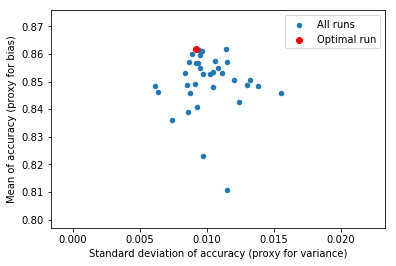

In [22]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
df.plot.scatter('acc_std', 'acc_mean')
plt.scatter(df['acc_std'][df['acc_mean'].idxmax()], df['acc_mean'][df['acc_mean'].idxmax()], color = 'red')
plt.legend(['All runs','Optimal run'])
plt.xlabel('Standard deviation of accuracy (proxy for variance)')
plt.ylabel('Mean of accuracy (proxy for bias)')
plt.show()

We can see that the optimal method in terms of accuracy is not bad in terms of variance either :) 

# Further analysis of the Bayesian optimizaiton  run
What parameters does the Bayesian optimization try?

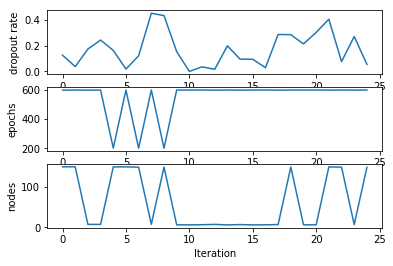

In [64]:
ep, node, d_rate = [],[],[]
for i in range(len(results['all']['params'])):
    ep.append(results['all']['params'][i]['epochs'])
    node.append(results['all']['params'][i]['numnode'])
    d_rate.append(results['all']['params'][i]['rate'])
plt.figure(1)
plt.subplot(311)
plt.plot(d_rate)
plt.ylabel('dropout rate')
plt.subplot(312)
plt.plot(ep)
plt.ylabel('epochs')
plt.subplot(313)
plt.plot(node)
plt.ylabel('nodes')
plt.xlabel('Iteration')
plt.show()

Seems like it tries extreme ends of the search space for nodes and epochs and more diverse values for the droput rate.
Dropout is a regularization mechanism. Let's see if in our experiment, high dropout rates correspond to less variance: 

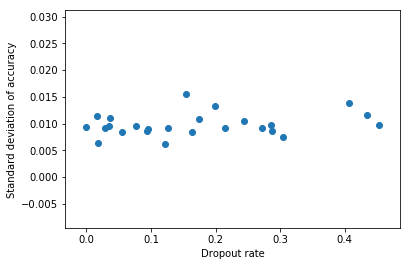

In [63]:
plt.scatter(d_rate, df['acc_std'].tolist()[10:])
plt.ylabel('Standard deviation of accuracy')
plt.xlabel('Dropout rate')
plt.show()

There does not seem to be such trend in this example.

# Conclusion
Bayesian optimization used for neural net tuning can get you gold medals!